# Sentiment analysis of reviews using BERT

This Notebook uses BERTTokenizer and TFBertModel available in the transformers library. Our approach here will be minimalistic with a little text cleaning and then encode our training and test data to tokens, masks and ids. Additionaly, usage of GPUs is a good option for training huge neural networks but with BERT they take 30-35 minutes per epoch to train, so to improve latency we will train our model on TPUs.

### import required libraries

In [1]:
import numpy as np 
import pandas as pd
from kaggle_datasets import KaggleDatasets

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from transformers import BertTokenizer, TFBertModel
from transformers import AdamWeightDecay as AdamW
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#import tensorflow_addons as tfa
#AdamW = tfa.optimizers.AdamW


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import string, re, nltk
from string import punctuation
from emoji import demojize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))        

/kaggle/input/nlpweek1/train.csv
/kaggle/input/nlpweek1/test.csv


### define necessary functions

In [2]:
"""cleaning reviews by throwing away user mentions, hastags, punctuations, web-urls/html links,
html tags, numbers and convert emojis to text"""
def text_cleaner(duh_texts):
    duh = duh_texts.lower() #to lower case
    duh = re.sub('(@[a-zA-z0-9_]+)','',duh) #usernames/twitter_handles
    duh = re.sub(r'(https?:|www)\S+', '', duh) #web-urls
    duh = re.sub(r'<.*?>', '', duh) #html tags(<b>,<br>,<a> et al)
    duh = re.sub('(&#?[a-zA-Z0-9]+;)','',duh) #hashtags/specialtags(#aim,#machinehack,#nlp et al)
    duh = demojize(duh) #convert emojis to text
    duh = re.sub(f'[{re.escape(punctuation)}]', ' ', duh) #substitute punctuations with space
    duh = re.sub(r'\b[0-9]+\b\s*', '', duh) #numbers
        
    return duh

In [3]:
"""for eda purpose below function takes text as input and generates a word cloud"""
def wordcloud(df):
    stopwords = set(STOPWORDS)
    stopwords.update("movie","film")
    d = {0:'Negative',1:'Neutral',2:'Positive'}
    plt.figure(figsize=(26,12))
    for i in df.Sentiment.unique():
        plt.subplot(3,1,i+1)
        #text = df[df['Sentiment']==i]['Review'].to_string()
        text = " ".join(review for review in df[df["Sentiment"]==i].Review)
        wordcloud = WordCloud(stopwords=stopwords, \
                              max_words=500,background_color="white").generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title("{0} reviews".format(d[i]),fontsize='24',fontweight='20')
        plt.axis("off")

In [4]:
"""this function returns a tree-map of bigrams based on frequency"""
def tree_maps(df):
        stopwords = set(STOPWORDS)
        vectorizer_bigram = CountVectorizer(ngram_range=(2,2),stop_words=stopwords,analyzer='word')
        sparse_matrix = vectorizer_bigram.fit_transform(df['reviews'])
        frequencies = sum(sparse_matrix).toarray()[0]
        bigram_df = pd.DataFrame(frequencies,index=vectorizer_bigram.get_feature_names(),columns=['frequency'])
        bigram_df.sort_values(['frequency'],axis=0,ascending=False,inplace=True)
        bigram_df.reset_index(inplace=True)
        bigram_df_top20 = bigram_df[:20]
        fig = px.treemap(bigram_df_top20,path=['index'],values='frequency',title='Tree of most occuring Bigrams')
        fig.show()

In [5]:
"""bert_encode function will transorm our data in a manner usable by BERT.As we know BERT model 
expects a dict with three int32 Tensors as input: input_word_ids, input_mask, and input_type_ids. 
Visit TensorflowHub and HuggingFace for more info"""

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

#bert has maximum limit of 512 tokens so max_len = 512
#text = text[:max_len-2] - since we are adding CLS and SEP tokens to our text

In [6]:
"""model with bert as a base layer"""

def build_model(bert_layer, max_len=512):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")

    bert_output = bert_layer(input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    clf_output = pooled_output
    ol = tf.nn.dropout(clf_output, rate=0.3)
    ol = Dense(768,activation='relu')(ol)
    #ol = Dropout(0.3)(ol)
    ol = Dense(384,activation='relu')(ol)
    #ol = Dropout(0.3)(ol)
    ol = Dense(192,activation='relu')(ol)
    ol = Dropout(0.3)(ol)
    ol = Dense(24,activation='relu')(ol)
    #ol = Dropout(0.3)(ol)
    #ol = Dense(12,activation='relu')(ol)
    #ol = Dropout(0.3)(ol)
    #out = Dense(3, activation='sigmoid')(clf_output)
    out = Dense(3, activation='sigmoid')(ol)
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=out)
    model.compile(AdamW(learning_rate=5e-6,weight_decay_rate=2.0), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### load data

In [7]:
df = pd.read_csv("/kaggle/input/nlpweek1/train.csv")
test = pd.read_csv("/kaggle/input/nlpweek1/test.csv")

### explore data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44100 entries, 0 to 44099
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         44100 non-null  int64 
 1   author     44100 non-null  object
 2   Review     44100 non-null  object
 3   Sentiment  44100 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      18900 non-null  int64 
 1   author  18900 non-null  object
 2   Review  18900 non-null  object
dtypes: int64(1), object(2)
memory usage: 443.1+ KB


In [10]:
df.isnull().sum()

ID           0
author       0
Review       0
Sentiment    0
dtype: int64

In [11]:
test.isnull().sum()

ID        0
author    0
Review    0
dtype: int64

In [12]:
df.Sentiment.value_counts()

0    19299
2    18733
1     6068
Name: Sentiment, dtype: int64

### Observations:

- No null values present in our datasets
- Negative and positive reviews are thrice as the neutral reviews

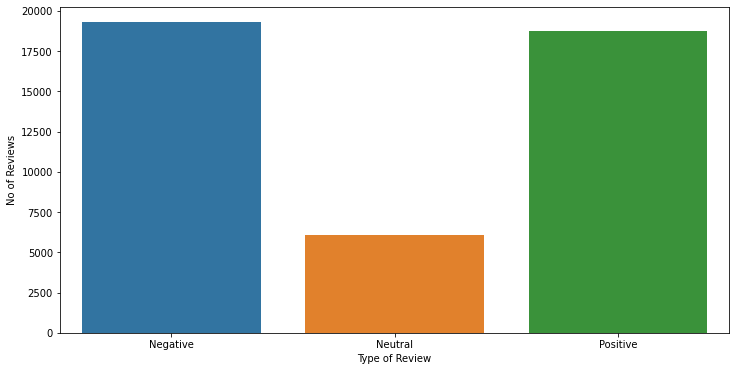

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(df.Sentiment)
plt.xlabel("Type of Review")
plt.ylabel("No of Reviews")
plt.xticks([0,1,2],labels=["Negative","Neutral","Positive"]);
plt.show()

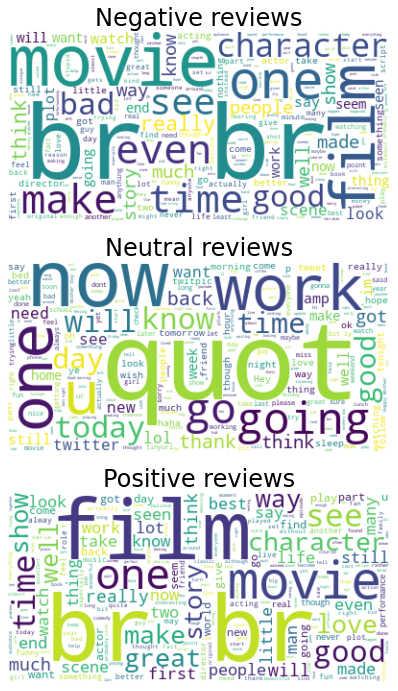

In [14]:
wordcloud(df)

### Observation:
- review contains lot of html tags, extracts
- there aren't any strong words to form the impression, maybe post cleaning this may change.

### preprocessing and splitting data for training and validation

In [15]:
df['reviews'] = df['Review'].apply(text_cleaner)

In [16]:
test['reviews'] = test['Review'].apply(text_cleaner)

In [17]:
print("Negative")
tree_maps(df[df['Sentiment']==0])

Negative


In [18]:
print("Neutral")
tree_maps(df[df['Sentiment']==1])

Neutral


In [19]:
print("Positive")
tree_maps(df[df['Sentiment']==2])

Positive


In [20]:
train,valid = train_test_split(df,random_state=45,test_size=0.2)

In [21]:
train_labels = pd.get_dummies(train.Sentiment)
valid_labels = pd.get_dummies(valid.Sentiment)

### setup TPU environment

In [22]:
"""below I'm leveraging TPUs powered by Google on Kaggle but you can use them on google colab notebooks as well,
this link describes how to use TPU on Google Colab https://colab.research.google.com/notebooks/tpu.ipynb"""

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [23]:
#to load private datasets on gcs
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

#Set the credentials
user_secrets.set_tensorflow_credential(user_credential)

In [24]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [25]:
# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 384

In [26]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

%%time
train_input = bert_encode(train.Review.astype(str), bert_tokenizer, max_len=MAX_LEN)
valid_input = bert_encode(valid.Review.astype(str), bert_tokenizer, max_len=MAX_LEN)
test_input = bert_encode(test.Review.astype(str), bert_tokenizer, max_len=MAX_LEN)

### feature embedding

In [27]:
%%time
train_input = bert_encode(train.reviews.astype(str), bert_tokenizer, max_len=MAX_LEN)
valid_input = bert_encode(valid.reviews.astype(str), bert_tokenizer, max_len=MAX_LEN)
test_input = bert_encode(test.reviews.astype(str), bert_tokenizer, max_len=MAX_LEN)

CPU times: user 3min 7s, sys: 1.03 s, total: 3min 8s
Wall time: 3min 8s


### convert inputs to tensor datasets

In [28]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_input, train_labels))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_input, valid_labels))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_input)
    .batch(BATCH_SIZE)
)

## Load model into TPU

In [29]:
%%time
with strategy.scope():
    bert_layer = (
        TFBertModel
        .from_pretrained('bert-base-uncased')
    )
    model = build_model(bert_layer, max_len=MAX_LEN)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

## Let's train

In [30]:
checkpoint = ModelCheckpoint('model.h5',monitor='val_loss', save_best_only=True, save_weights_only=True)
n_steps = train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS*2,
    callbacks=[checkpoint]
)

Epoch 1/6
275/275 [==============================] - 145s 267ms/step - loss: 0.9576 - accuracy: 0.4974 - val_loss: 0.6782 - val_accuracy: 0.7161
Epoch 2/6
275/275 [==============================] - 57s 207ms/step - loss: 0.6779 - accuracy: 0.7115 - val_loss: 0.6372 - val_accuracy: 0.7344
Epoch 3/6
275/275 [==============================] - 57s 208ms/step - loss: 0.6289 - accuracy: 0.7405 - val_loss: 0.6328 - val_accuracy: 0.7406
Epoch 4/6
275/275 [==============================] - 57s 207ms/step - loss: 0.5947 - accuracy: 0.7529 - val_loss: 0.6303 - val_accuracy: 0.7406
Epoch 5/6
275/275 [==============================] - 57s 207ms/step - loss: 0.5713 - accuracy: 0.7670 - val_loss: 0.6278 - val_accuracy: 0.7433
Epoch 6/6
275/275 [==============================] - 57s 207ms/step - loss: 0.5403 - accuracy: 0.7792 - val_loss: 0.6408 - val_accuracy: 0.7368


In [31]:
model.load_weights('model.h5')

In [32]:
model.evaluate(valid_dataset)

69/69 [==============================] - 5s 59ms/step - loss: 0.6275 - accuracy: 0.7416


[0.6274606585502625, 0.7416099905967712]

In [33]:
test_pred = model.predict(test_input)

In [34]:
submit = pd.DataFrame(test_pred,columns=["Negative_0","Neutral_1","Positive_2"])

In [35]:
submit.to_csv('submission-nlp.csv', index=False)

## End